In [195]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Loading datasets

In [196]:
fitbit_daily_activity_df = pd.read_csv('../../../../data/client_data/cleaned/fitbit/cleaned_fitbit_grouped_dups.csv')
fitbit_daily_activity_df.head()

,id,sleep_target,sleep_value,steps,calories_target,calories_value,createdAt,updatedAt,intensity,min_heart_rate,max_heart_rate,user/id,user/email,user/full_name,user/disable_survey
0,13,480,403.0,8416.0,2048.0,1748.0,2023-05-08 17:56:01.406000+00:00,2023-05-09 23:56:02.232000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18,480,383.0,9753.0,2048.0,1848.0,2023-05-10 00:00:03.442000+00:00,2023-05-11 23:56:04.105000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,480,462.0,273.0,2048.0,1199.0,2023-05-12 00:00:03.483000+00:00,2023-05-13 23:56:03.522000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28,480,421.0,2504.0,2048.0,745.0,2023-05-14 00:00:03.142000+00:00,2023-05-15 10:28:03.909000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33,480,421.0,11681.0,2048.0,2025.0,2023-05-15 12:00:04.019000+00:00,2023-05-15 23:55:04.824000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Get day of data record

In [197]:
# convert datetime columns to datatime data type:
fitbit_daily_activity_df['updatedAt'] = pd.to_datetime(fitbit_daily_activity_df['updatedAt'])
fitbit_daily_activity_df['createdAt'] = pd.to_datetime(fitbit_daily_activity_df['createdAt'])

In [198]:
# Note the first 4 days are longer than 1 day 
x = fitbit_daily_activity_df['updatedAt'] - fitbit_daily_activity_df['createdAt']
x.sort_values()[::-1]

1    1 days 23:56:00.663000
2    1 days 23:56:00.039000
3    1 days 10:28:00.767000
0    1 days 06:00:00.826000
76   0 days 23:55:02.347000
              ...          
61   0 days 00:30:00.258000
58   0 days 00:29:59.933000
6           0 days 00:00:00
51          0 days 00:00:00
72          0 days 00:00:00
Length: 80, dtype: timedelta64[ns]

In [203]:
fitbit_daily_activity_df[~fitbit_daily_activity_df['intensity'].isna()]['intensity'].describe()

count     42.000000
mean      39.190476
std       36.662760
min       10.000000
25%       13.000000
50%       29.500000
75%       44.000000
max      188.000000
Name: intensity, dtype: float64

In [176]:
fitbit_daily_activity_df['steps'].describe()

count       73.000000
mean      7477.534247
std       4542.362360
min          7.000000
25%       5422.000000
50%       7697.000000
75%       9372.000000
max      29384.000000
Name: steps, dtype: float64

In [177]:
# only focusing on steps since the intensity values aren't clear on what they represent
steps_df = fitbit_daily_activity_df[['steps']]
steps_df.head()

,steps
0,8416.0
1,9753.0
2,273.0
3,2504.0
4,11681.0


# Feature Scaling and Transformation

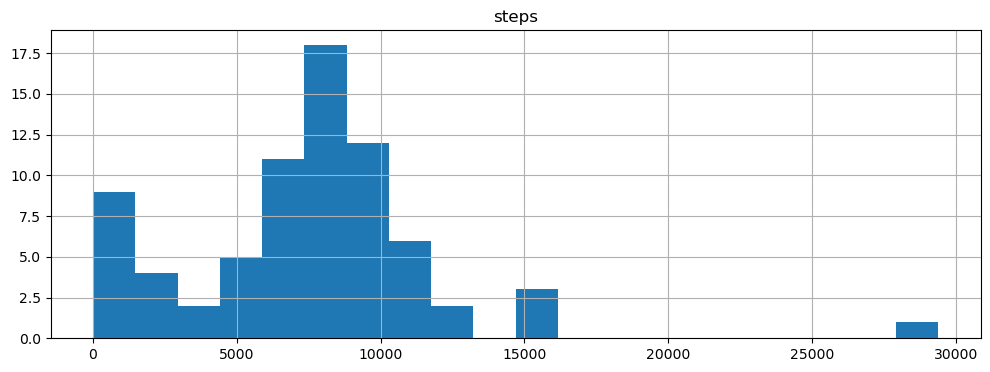

In [178]:
# inspecting the distribution of each feature:
fig, axis = plt.subplots(figsize=(12, 4))
steps_df.hist(ax=axis, bins=20)
plt.show()

In [179]:
steps_df.skew()

steps    1.313359
dtype: float64

In [180]:
before_unskewed_df = steps_df.copy() #(for comparison after)

In [181]:
def box_cox_transformation(feature, l):
    transform = ColumnTransformer(transformers=[("box-cox", FunctionTransformer(lambda X: stats.boxcox(X, lmbda=l)), [feature])])
    # return pd.DataFrame(transform.fit_transform(activity_steps_df))
    return transform.fit_transform(steps_df)

In [182]:
steps_df['steps'] = box_cox_transformation(feature="steps", l=0.7)

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_73718/2804551451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steps_df['steps'] = box_cox_transformation(feature="steps", l=0.7)


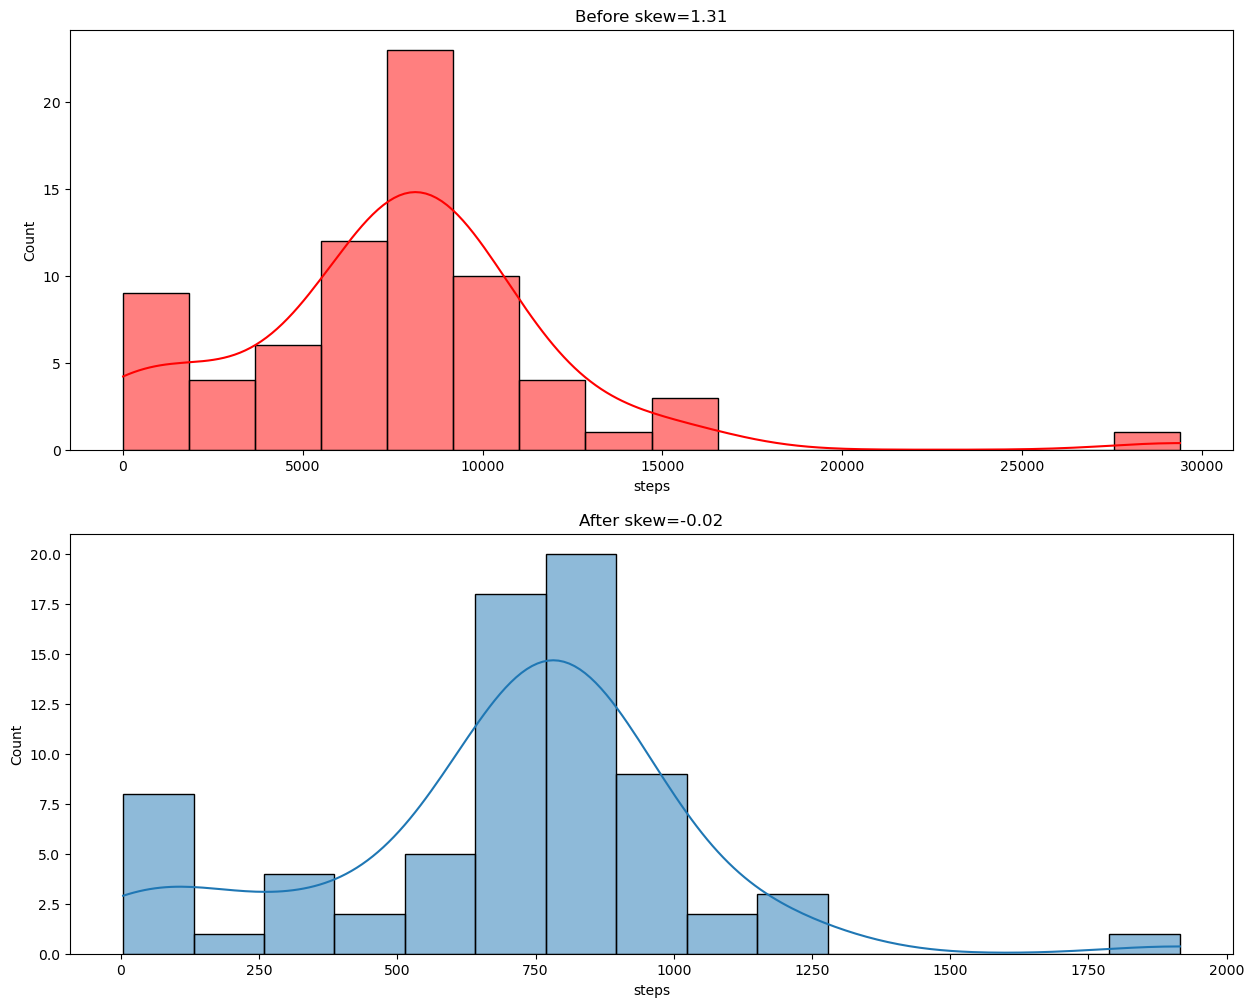

In [183]:

fig, ax = plt.subplots(2, 1, figsize=(15,12))
# activity_steps_df.hist(ax=ax, bins=20)
sns.histplot(before_unskewed_df['steps'], kde=True, ax=ax[0], color='red').set(title=f"Before skew={before_unskewed_df['steps'].skew():0.2f}")
sns.histplot(steps_df['steps'], kde=True, ax=ax[1]).set(title=f"After skew={steps_df['steps'].skew():0.2f}")


plt.show()

In [184]:
steps_df.describe()

,steps
count,73.000000
mean,698.276272
std,329.479440
min,4.149327
25%,585.808710
50%,749.030481
75%,859.931143
max,1915.383787


# Remove Nans

In [185]:
steps_df.isna().sum()

steps    7
dtype: int64

In [186]:
steps_df = steps_df.dropna()

In [187]:
steps_df.isna().sum()

steps    0
dtype: int64

In [188]:
# no scaling needed since we have only 1 feature

# K-means clustering

In [189]:

#! number of clusters?
kmeans_labels = KMeans(n_clusters=5, random_state=0).fit_predict(steps_df.values)
# kmeans.labels_

In [190]:
kmeans_labels

array([0, 0, 1, 1, 3, 0, 1, 4, 0, 0, 0, 0, 3, 0, 0, 4, 4, 3, 3, 4, 0, 0,
       0, 3, 0, 3, 4, 4, 0, 0, 0, 2, 3, 0, 1, 4, 0, 4, 4, 0, 0, 0, 0, 4,
       0, 4, 4, 4, 0, 1, 1, 4, 4, 4, 1, 0, 0, 0, 1, 3, 0, 4, 0, 4, 1, 1,
       1, 1, 4, 4, 4, 0, 1], dtype=int32)

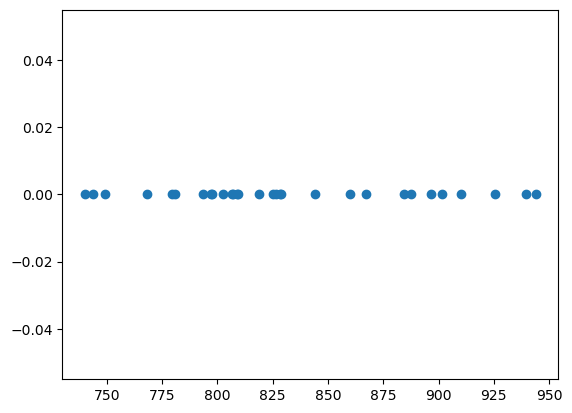

In [191]:
plt.scatter(steps_df[kmeans_labels == 0]['steps'], [0] * steps_df[kmeans_labels == 0].shape[0])

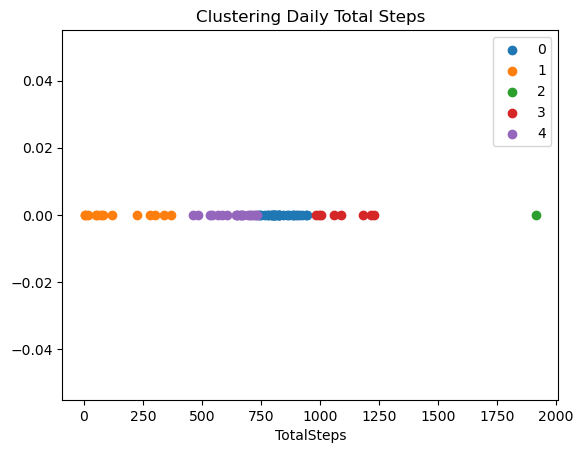

In [194]:
#Getting unique labels
 
u_labels = np.unique(kmeans_labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(steps_df[kmeans_labels == i]['steps'], ([0] * steps_df[kmeans_labels == i].shape[0]), label = i)
plt.legend()

plt.title("Clustering Daily Total Steps")
plt.xlabel('TotalSteps')
# plt.ylabel('TotalActivityMinutes')
plt.show()

In [193]:
# can then use this model to predict which cluster a user's daily data would fit into, and perhaps get the average group over a week?